In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, VarianceThreshold

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans
import xgboost as xgb

# Metrics
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
from filter_functions import drop_low_var, drop_correlated
from functions import regression_metrics, grid_search_results

## Main Task: Regression Problem

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
data = pd.read_csv('data/regression_data.csv')

In [5]:
data.head()

,Unnamed: 0,type_is_Adverse_x,type_is_Clear_x,type_is_Light_x,type_is_Moderate_x,type_is_Severe_x,type_is_Adverse_y,type_is_Clear_y,type_is_Light_y,type_is_Moderate_y,...,fl_num_on_time_pct,origin_on_time_pct,route_on_time_pct,origin_taxi_out,carrier_fuel_consumption,mean_taxi_in,carrier_mean_delay,origin_mean_dep_delay,dest_mean_arr_delay,arr_delay
0,0,0,1,1,0,0,0,1,1,0,...,0.367852,1.155770,0.042167,-0.475455,-1.159495,1.081105,-0.19294,0.990275,0.569036,-7.0
1,1,1,0,1,0,0,1,0,1,0,...,0.414815,-0.010761,-1.090683,-0.932123,-0.710796,1.081105,-0.19294,1.817218,1.184652,13.0
2,2,0,1,1,0,0,0,1,1,0,...,0.079782,-0.375917,-0.340825,-0.216023,0.888111,1.081105,-0.19294,-0.189890,1.184652,-5.0
3,3,0,1,1,0,0,0,1,1,0,...,-1.322857,-0.526199,0.272626,-0.662034,-0.139927,1.081105,-0.19294,0.397533,-0.453026,-6.0
4,4,0,1,1,0,0,1,0,1,0,...,-1.322857,-0.946699,-0.542943,1.470320,-0.811735,1.081105,-0.19294,0.118298,-0.764628,6.0


In [6]:
data.shape

(1079053, 33)

In [7]:
# Separate the target feature from the regression data

target = data['arr_delay']
data = data.drop(columns = ['arr_delay', 'Unnamed: 0'])

In [8]:
data.dtypes

type_is_Adverse_x             int64
type_is_Clear_x               int64
type_is_Light_x               int64
type_is_Moderate_x            int64
type_is_Severe_x              int64
type_is_Adverse_y             int64
type_is_Clear_y               int64
type_is_Light_y               int64
type_is_Moderate_y            int64
type_is_Severe_y              int64
type_is_Friday                int64
type_is_Monday                int64
type_is_Saturday              int64
type_is_Sunday                int64
type_is_Thursday              int64
type_is_Tuesday               int64
type_is_Wednesday             int64
distance                    float64
crs_dep_hour                float64
crs_arr_hour                float64
carrier_on_time_pct         float64
plane_on_time_pct           float64
fl_num_on_time_pct          float64
origin_on_time_pct          float64
route_on_time_pct           float64
origin_taxi_out             float64
carrier_fuel_consumption    float64
mean_taxi_in                

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?
- PCA vs LDA?
- Check for high correlation, low variance
- Try some wrapper methods

Try dropping features with low variance

In [9]:
# Create an alias for our regression data
data_train = data

### Drop features with low variance

In [10]:
data_train = drop_low_var(0.1, data_train)
data_train.shape

(1079053, 25)

### Drop features that are highly correlated

In [11]:
data_train = drop_correlated(0.7, data_train)

<AxesSubplot:>

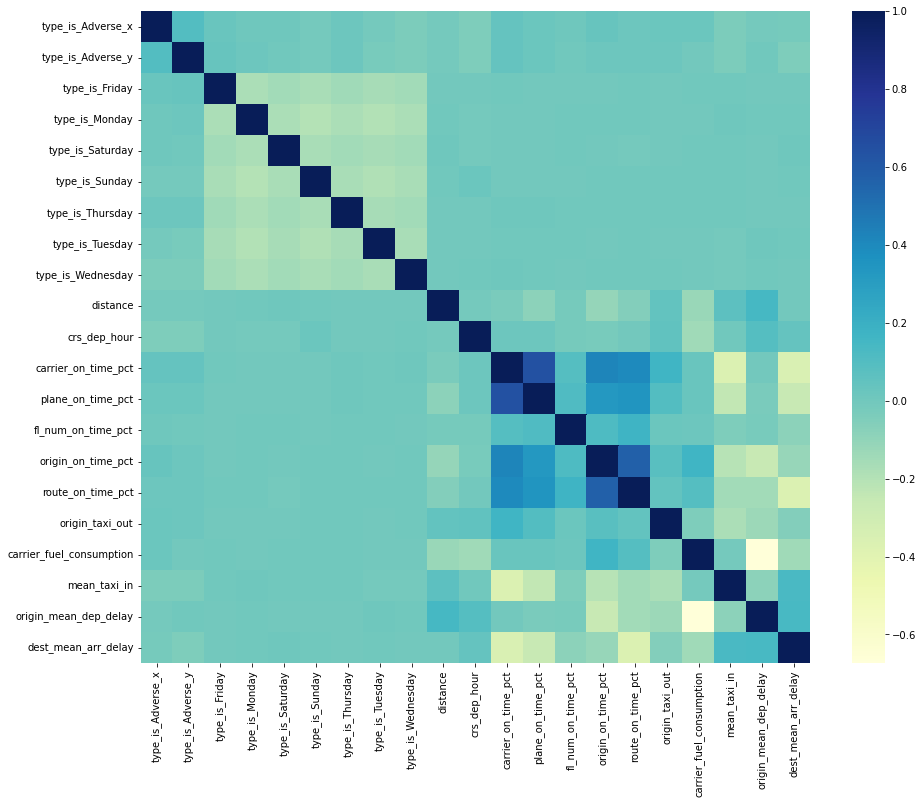

In [12]:
df_corr = data_train.corr()
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(df_corr, annot = False, cmap="YlGnBu")


In [13]:
print(data_train.shape)
dropped_cols = data.columns.to_list() not in data_train.columns.to_list()
data_train.columns.to_list()

(1079053, 21)


['type_is_Adverse_x',
 'type_is_Adverse_y',
 'type_is_Friday',
 'type_is_Monday',
 'type_is_Saturday',
 'type_is_Sunday',
 'type_is_Thursday',
 'type_is_Tuesday',
 'type_is_Wednesday',
 'distance',
 'crs_dep_hour',
 'carrier_on_time_pct',
 'plane_on_time_pct',
 'fl_num_on_time_pct',
 'origin_on_time_pct',
 'route_on_time_pct',
 'origin_taxi_out',
 'carrier_fuel_consumption',
 'mean_taxi_in',
 'origin_mean_dep_delay',
 'dest_mean_arr_delay']

# PCA

Perform principal component analysis on the data to see if dimensionality reduction has an impact on the scores of our models.  
Spoiler alert, it doesn't.

In [14]:
# Initialize pca with components = 2
n_components = data_train.shape[1]
pca = PCA(n_components = n_components)
components = pca.fit_transform(data_train)

In [15]:
# Calculate and print the total variance
total_variance = pca.explained_variance_ratio_.sum() * 100
total_variance

100.0

In [16]:
pca.explained_variance_ratio_ * 100

array([2.17434313e+01, 1.33599447e+01, 8.27150810e+00, 7.90267220e+00,
       7.52709645e+00, 7.15663940e+00, 6.59536487e+00, 5.71680445e+00,
       5.53873376e+00, 2.77118832e+00, 2.41297433e+00, 1.97413038e+00,
       1.42073556e+00, 1.27436529e+00, 1.19628886e+00, 1.15228142e+00,
       1.09169779e+00, 9.79072665e-01, 9.64687033e-01, 9.50383070e-01,
       4.34839932e-27])

Text(0.5, 1.0, 'Scree plot for 25 Component PCA Analysis')

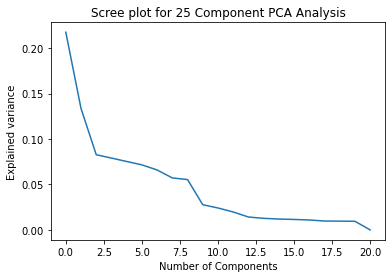

In [17]:
plt.plot(range(n_components), pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained variance')
plt.title('Scree plot for 25 Component PCA Analysis')

In [18]:
# Reinitialize PCA with 5 components
n_components = 8
pca = PCA(n_components = n_components)
components = pca.fit_transform(data)

In [19]:
pca.explained_variance_ratio_ * 100

array([22.39953791, 12.47813515,  9.73159557,  6.97191209,  6.52452938,
        6.1650566 ,  5.54772439,  5.06862988])

# Clustering

Try clustering our data to see if there is any positive impact on the model by including clustering data

In [20]:
# def plot_distortion(X,max_clusters = 15):
#     distortions = []
#     for i in range(1, max_clusters +1):
#         km = KMeans(n_clusters=i,
#                     init='k-means++',
#                     n_init=10,
#                     random_state=0)
#         km.fit(X)
#         distortions.append(km.inertia_)

#     plt.plot(range(1,max_clusters +1), distortions, marker='o')
#     plt.xlabel('Number of clusters')
#     plt.ylabel('Distortion')
#     plt.show() 

In [21]:
# plot_distortion(data_train, 10)

In [22]:
# # Initialize the kmeans object with 3 clusters
# k_means = km = KMeans(n_clusters = 3,
#            n_init = 10,
#            random_state = 13)

In [23]:
# # Establish predicitons, assign the label to the dataset
# y_km = km.fit_predict(data_train)
# data_train['kmeans_label'] = y_km



# Train Test Split

Do two train test splits.  One for the standard data and another for data that underwent PCA

In [24]:
X_train, X_val, y_train, y_val = train_test_split(data_train, target, test_size = 0.25, random_state = 13)

In [25]:
X_train_pca, X_val_pca, y_train_pca, y_val_pca  = train_test_split(components, target, test_size = 0.25)

# Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

# Random Forest

In [26]:
# rfr = RandomForestRegressor(n_estimators = 100,
#                             max_depth = 5)
# rfr.fit(X_train, y_train)
# 

In [27]:
# y_pred_rfr = rfr.predict(X_val)

In [28]:
# regression_metrics(y_val, y_pred_rfr)

# Linear Regression


Baseline r2 = 0.0477 <br>
PCA 20 component r2 = 0.383<br>

Benchmark:<br>
R2 Score:  0.09674605119603319<br>
Mean Absolute Error:  10.34<br>
Mean Squared Error:  179.70<br>


In [29]:
# Linear regression on raw data
l_reg = LinearRegression()
l_reg.fit(X_train, y_train)

LinearRegression()

In [30]:
y_pred_l_reg = l_reg.predict(X_val)

In [31]:
l_reg.coef_

array([ 2.01908308e+00,  2.99352086e+00,  8.99003236e+09,  8.99003236e+09,
        8.99003236e+09,  8.99003236e+09,  8.99003236e+09,  8.99003236e+09,
        8.99003236e+09, -1.10073520e+00,  3.09013704e-01,  9.80799854e-02,
       -1.49210403e+00, -1.16107669e+00, -4.02872739e-01, -2.30220957e+00,
       -7.12790623e-01, -4.27239541e-01, -1.52570749e-01,  8.71109637e-02,
        2.76789311e-01])

In [32]:
regression_metrics(y_val, y_pred_l_reg)

R2 Score:  0.09530412395891297
Mean Absolute Error:  10.346611195347618
Mean Squared Error:  180.15925422402674


In [33]:
current_data = data_train.columns.to_list()

In [34]:
coef_dict = dict(zip(current_data, l_reg.coef_))
coef_df = pd.Series(coef_dict)
coef_df.sort_values()
                

route_on_time_pct          -2.302210e+00
plane_on_time_pct          -1.492104e+00
fl_num_on_time_pct         -1.161077e+00
distance                   -1.100735e+00
origin_taxi_out            -7.127906e-01
carrier_fuel_consumption   -4.272395e-01
origin_on_time_pct         -4.028727e-01
mean_taxi_in               -1.525707e-01
origin_mean_dep_delay       8.711096e-02
carrier_on_time_pct         9.807999e-02
dest_mean_arr_delay         2.767893e-01
crs_dep_hour                3.090137e-01
type_is_Adverse_x           2.019083e+00
type_is_Adverse_y           2.993521e+00
type_is_Tuesday             8.990032e+09
type_is_Saturday            8.990032e+09
type_is_Sunday              8.990032e+09
type_is_Wednesday           8.990032e+09
type_is_Monday              8.990032e+09
type_is_Thursday            8.990032e+09
type_is_Friday              8.990032e+09
dtype: float64

In [35]:
# selector = RFE(estimator = l_reg,
#               )
# selector = selector.fit(X_train, y_train)
# selector.support_

# Ridge

Benchmark: <br>
R2 Score:  0.1010<br>
Mean Absolute Error:  10.30<br>
Mean Squared Error:  179.02<br>


In [36]:
ridge = Ridge(alpha = 75)
ridge.fit(X_train, y_train)
ridge.coef_

array([ 2.01819906,  2.9919428 ,  0.91214212,  0.2324736 , -0.37437509,
       -0.3247415 ,  0.61309503, -0.88119238, -0.17740178, -1.10063445,
        0.30893884,  0.09789134, -1.49189092, -1.16101059, -0.40297231,
       -2.30190868, -0.71268437, -0.42712853, -0.15256867,  0.08720187,
        0.27683358])

In [37]:
ridge_predict = ridge.predict(X_val)

In [38]:
regression_metrics(y_val, ridge_predict)

R2 Score:  0.09530398403155815
Mean Absolute Error:  10.346600354857518
Mean Squared Error:  180.159282088869


In [39]:
params = {'alpha':[50, 75, 100, 150, 1000]
         }

In [40]:
grid_ridge = GridSearchCV(estimator = ridge,
                       param_grid = params,
                       cv = 5)
grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(alpha=75),
             param_grid={'alpha': [50, 75, 100, 150, 1000]})

In [41]:
grid_search_results(grid_ridge, X_train, y_train)

Best Score:  0.09613982925929021
Best Params:  {'alpha': 150}


# Lasso

Benchmark: <br>
R2 Score:  0.1010<br>
Mean Absolute Error:  10.30<br>
Mean Squared Error:  179.02<br>

In [42]:
lasso = Lasso(alpha = 0.0001)
lasso.fit(X_train, y_train)

Lasso(alpha=0.0001)

In [43]:
lasso_predict = lasso.predict(X_val)

In [44]:
regression_metrics(y_val, lasso_predict)

R2 Score:  0.09530395664140112
Mean Absolute Error:  10.346602741946485
Mean Squared Error:  180.15928754328786


In [45]:
params = {'alpha':[0.001,0.01, 0.1, 1, 10]
         }

grid_lasso = GridSearchCV(estimator = lasso,
                       param_grid = params,
                       cv = 5)
grid_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(alpha=0.0001),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10]})

In [46]:
grid_search_results(grid_lasso, X_train, y_train)

Best Score:  0.09613951098748474
Best Params:  {'alpha': 0.001}


# Linear Regression on PCA Components
Benchmark:<br>
R2 Score:  0.07661184040454239<br>
Mean Absolute Error:  10.440522872762424<br>
Mean Squared Error:  183.40646489367066<br>



In [47]:
# Linear regression on components
l_reg_pca = LinearRegression()
l_reg_pca.fit(X_train_pca, y_train_pca)

LinearRegression()

In [48]:
y_pred_l_reg_pca = l_reg_pca.predict(X_val_pca)

In [49]:
regression_metrics(y_val_pca, y_pred_l_reg_pca)

R2 Score:  0.07428209854545464
Mean Absolute Error:  10.441192400996588
Mean Squared Error:  183.93949033837873


# XGBoost -  Using Train Test Split
Bennchmark:<br>
r2 - .1457<br>
MAE - 10.03<br>
MSE - 170.23<br>
n_estimators = 150,
                         max_depth = 10,

In [50]:
xgb_r = xgb.XGBRegressor(objective = 'reg:squarederror',
                        eta = 0.3,
                         n_estimators = 125,
                         max_depth = 7,
                         seed = 13,
                        tree_method = 'hist')

In [51]:
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=125, n_jobs=8, num_parallel_tree=1, random_state=13,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=13,
             subsample=1, tree_method='hist', validate_parameters=1,
             verbosity=None)

In [52]:
# Save model to disk
filename_xgbr_model = 'xgbr_best.sav'
pickle.dump(xgb_r, open('pickle_jar/'+filename_xgbr_model, 'wb'))

In [53]:
y_xgb = xgb_r.predict(X_val)

In [54]:
regression_metrics(y_val, y_xgb)

R2 Score:  0.13623948967022426
Mean Absolute Error:  10.102532937695477
Mean Squared Error:  172.00747067637772


In [55]:
# params = {'n_estimators': [75, 100, 125],
#           'max_depth': [5,6,7],
#           'tree_method': ['hist']
#          }

In [56]:
# grid_xgb = GridSearchCV(estimator = xgb_r,
#                        param_grid = params,
#                        cv = 5, scoring = 'r2')

In [57]:
# grid_xgb.fit(X_train, y_train)
# grid_xgb.best_estimator_

In [58]:
# grid_search_results(grid_xgb, X_train, y_train)

# KFold Cross Validation on XGBoost Regressor Model

Comparing model performance using K-Fold cross-validation to our train test split data.  These values started to make a lot more sense after itintializing KFold() with shuffle = True

In [59]:
model = xgb.XGBRegressor(objective = 'reg:squarederror',
                        eta = 0.35,
                         n_estimators = 125,
                         max_depth = 7,
                         seed = 13,
                        tree_method = 'hist')

In [60]:
kf = KFold(shuffle = True, n_splits = 10)
scores = cross_val_score(model, data_train, target, cv=kf, scoring = 'r2')
print(f'Scores: {scores}')
print(f'Average score: {sum(scores)/10}')

Scores: [0.13997911 0.13953803 0.13841354 0.13871895 0.13540799 0.14210806
 0.13843172 0.14148167 0.1405132  0.14118817]
Average score: 0.13957804398108847


# KFold Cross Validation on Ridge Regression Model
Comparing model performance with Ridge regression for reference.

In [61]:
kf = KFold(n_splits = 10, shuffle = True)
model = Ridge(alpha = 75)

In [62]:
scores = cross_val_score(model, data_train, target, cv=kf, scoring = 'r2')
print(f'Scores: {scores}')
print(f'Average score: {sum(scores)/10}')

Scores: [0.097453   0.09574355 0.09813028 0.09413177 0.09506904 0.09323582
 0.09690789 0.09443309 0.09959311 0.094113  ]
Average score: 0.09588105334776534


# Evaluation
Time for the rubber to hit the road. 

In [63]:
# # Import the test dataset that has the same features as our model is expecting

test_data = pd.read_csv('data/test_data_prepped.csv')
test_data.shape

(150623, 22)

In [64]:
# # Drop the pesky Unnamed: 0 column
test_data.drop(columns = 'Unnamed: 0', inplace=True)
test_data.shape

(150623, 21)

### We will be predicting our delay values using the XGBoost regressor model as it was consistently the best model that we trained.

The r2 values were always higher than any other model by about .05 and the model was generalized enough to return good scores even with train test splits as low as 50/50.

### Let's retrain the model on the entire data set.

In [65]:
final_model = xgb_r = xgb.XGBRegressor(objective = 'reg:squarederror',
                        eta = 0.3,
                         n_estimators = 125,
                         max_depth = 7,
                         seed = 13,
                        tree_method = 'hist')
final_model.fit(data_train, target)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=125, n_jobs=8, num_parallel_tree=1, random_state=13,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=13,
             subsample=1, tree_method='hist', validate_parameters=1,
             verbosity=None)

In [66]:
# make predicitions on the test data
y_predictions = final_model.predict(test_data)

In [67]:
# load the formatted test data to make our submission
pre_submit = pd.read_csv('data/pre_predictions.csv')

In [70]:
import copy
submission = copy.deepcopy(pre_submit)
submission['predictions'] = y_predictions
submission.drop('Unnamed: 0', axis = 1, inplace=True)
submission.head()

,fl_date,mkt_carrier,mkt_carrier_fl_num,origin,dest,predictions
0,2020-01-01,WN,5888,ONT,SFO,-3.055469
1,2020-01-01,WN,6276,ONT,SFO,-3.919202
2,2020-01-01,WN,4598,ONT,SJC,-4.636937
3,2020-01-01,WN,4761,ONT,SJC,-4.839359
4,2020-01-01,WN,5162,ONT,SJC,-7.545444


In [71]:
submission.to_csv('data/submission.csv')

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

## Because this is a classification problem, we will want to rectify the massive class imbalance between labels for these algorithms. 

In [ ]:
multiclass = pd.read_csv('data/multiclass_data.csv')
multiclass.head()

In [ ]:
multi_target = multiclass.delay_reason
multiclass.drop('delay_reason',axis = 1, inplace=True)

In [ ]:
# Initiate a new train test split based on the multiclass target
X_train, X_val, y_train, y_val = train_test_split(multiclass, multi_target, test_size = 0.25, random_state = 13)

# SVM

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)

In [ ]:
y_svc_predict = svc.predict(X_val)

In [ ]:
multiclassifier_metrics(y_svc_predict, y_val)

# Naive Bayes

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

In [ ]:
gnb_predict = gnb.predict(X_val)

In [ ]:
multiclassifier_metrics(gnb_predict, y_val)

# XGBoost

In [ ]:
xgb_c = xgb.XGBClassifier()
xgb_c.fit(X_train, y_train)


In [ ]:
y_xgb_c = xgb_c.predict(X_val)

In [ ]:
multiclassifier_metrics(y_xgb_c, y_val)

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.